# B – Neutron-Nucleus Recoil Distributions

Objective
-
This notebook computes the **distribution of nuclear recoil energies** resulting from **neutron elastic scattering**. This is a key input for background modeling in rare event searches, such as dark matter experiments.

The recoil energy deposited in a detector depends on:
- the energy of the incident neutron,
- the mass of the target nucleus,
- and the scattering kinematics.

By computing the differential recoil spectrum, we obtain insight into how neutrons of known energy deposit measurable signals into a material like silicon.

---


We begin by selecting the target material and retrieving its atomic mass. This information is essential for determining the maximum possible energy transferred to a nucleus during an elastic collision.

We will then simulate neutrons with a fixed energy (e.g. 1 MeV). This energy governs how much kinetic energy is available to be transferred to the target nucleus.

Then we calculate the differential recoil cross section $\frac{d\sigma}{dE_r}$, which tells us how likely it is for a neutron of energy $E_n$ to produce a specific recoil energy $E_r$.

Libraries and Style Files
-------------------------

In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

#math tools
import numpy as np
import pandas as pd
import scipy.constants as co
import ENDF6el as endfel

Recoil Energy Distributions for Neutron-Nucleus Scattering
==========================================================

In the previous notebook `A-Differential-Neutron-Nucleus-XN.ipynb` we found out how our libraries can extract the Center-of-Mass (CoM) _angular_ differential cross sections for neutron scattering off nuclei. These cross sections describe the probability of scattering at different angles (in the center-of-mass frame). However, detectors do not directly measure angles—they measure recoil energy deposited by the recoiling nucleus. Therefore, we need to convert angular distributions into recoil energy distributions. In other words, we need to transform the angular variable in the CoM (say, $cos\theta_{cm}$) to the energy deposited into the detector. 

Energy Relationship
-------------------

The relationship between the nuclear recoil energy $E_r$ and the CoM scattering angle $\theta_{cm}$ is:

\begin{equation}
E_r = \frac{2m_n M E_n}{(m_n + M)^2}\left(1-\cos{\theta_{cm}}\right),
\end{equation}

Where:<br /><br />
$E_r$ is the recoil energy of the nucleus.<br />
$E_n$ is the energy of the incident neutron.<br />
$m_n$ is the mass of the neutron.<br />
$M$ is the mass of the nucleus.<br />
$\theta_{cm}$ is the scattering angle in the center-of-mass frame.


Load Differential Cross Section Data
-
We use the function `fetch_diff_xn()` to get the angular differential cross section, $\frac{d\sigma}{d\Omega}$ as a function of $cos\theta_{cm}$.

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import ENDF6el as endfel

# Generate Legendre coefficient interpolants for each Si isotope
acoeffs = {
    28: endfel.al(np.arange(64), endffile='../data_files/xn_data/n-014_Si_028.endf'),
    29: endfel.al(np.arange(64), endffile='../data_files/xn_data/n-014_Si_029.endf'),
    30: endfel.al(np.arange(64), endffile='../data_files/xn_data/n-014_Si_030.endf')
}

# Use shared total elastic cross-section file for all isotopes
f_elastic = endfel.fetch_elastic(filename='../data_files/xn_data/si28_el.txt')

# Build dictionary of differential cross section functions at 1 MeV
dsdomeg_funcs = {}
for A, acoeff in acoeffs.items():
    dsdomeg_funcs[A] = endfel.fetch_diff_xn(En=1.0e6, f=f_elastic, a=acoeff)


Encode Recoil Energy Formula
-

In [3]:
# import custom Python module containing atomic mass values
import masses as ms

# make a list of 100 evenly spaced values for cosθ
ct = np.linspace(-1.0, 1.0, 100)

# Define silicon isotope data: (Z=14, A)
si_isotopes = {
    28: ms.getMass(14, 28),
    29: ms.getMass(14, 29),
    30: ms.getMass(14, 30)
}

# Precompute recoil energy fractions (escale) for each isotope
fac_dict = {}
for A, m in si_isotopes.items():
    fac_dict[A] = ms.m_n * m / (ms.m_n + m)**2

Convert $\frac{d\sigma}{d\Omega}$ into $\frac{d\sigma}{dE_r}$.
-
Whereas we previously worked with cross section vs. angle, we now are working with cross section vs. energy. Thus, we must convert the angular cross section into one based on recoil energy.

Since angle and energy are related, we must change variables using the Jacobian, which compensates for how one variable “stretches” into another.

In [4]:
# Set up isotope list for Silicon with mass numbers
si_isotopes = {
    28: 0.92223,  # relative abundance
    29: 0.04685,
    30: 0.03092
}

# Compute Jacobian factors for each isotope
jacobians = {}
for A, abundance in si_isotopes.items():
    fac = A * (1 + A)**2
    jacobians[A] = (1 / (2 * fac)) * 2 * np.pi

Plot Recoil Energy Distributions for Different Neutron Energies
-
Now we compute and plot $\frac{d\sigma}{dE_r}$ for several incident neutron energies: 0.5 MeV, 1.0 MeV, and 1.5 MeV.

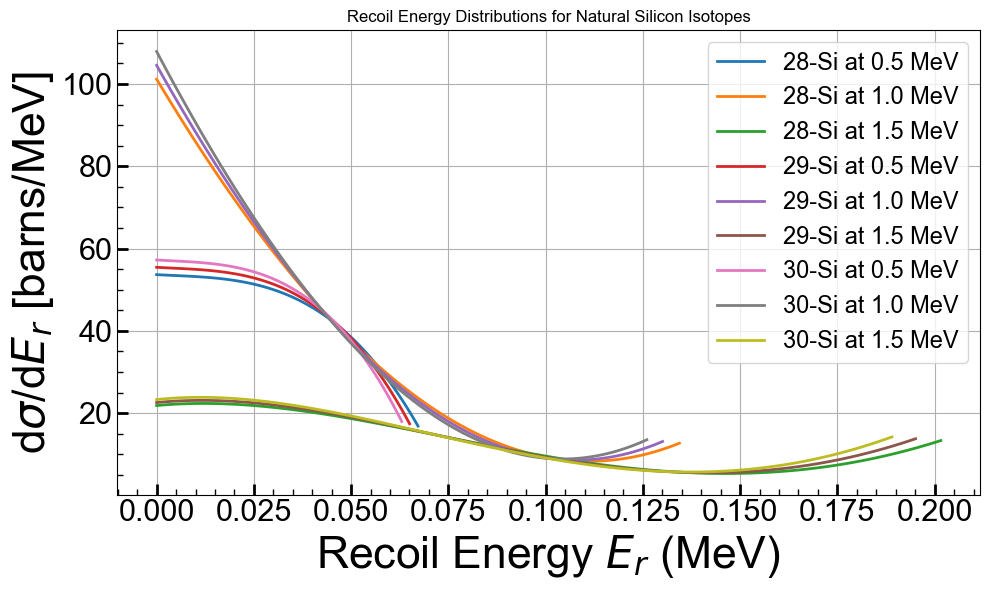

In [8]:
# List of incident neutron energies (in MeV)
energies = [0.5, 1.0, 1.5]

# Set up the plot
plt.figure(figsize=(10, 6))

for A in si_isotopes:
    fac = fac_dict[A]
    for E_n in energies:
        escale = 2 * fac * (1 - ct)
        er_vals = E_n * escale

        # Use precomputed function if E_n = 1 MeV, else re-fetch
        if E_n == 1.0:
            dsdomeg = dsdomeg_funcs[A]
        else:
            dsdomeg = endfel.fetch_diff_xn(En=E_n * 1e6, f=f_elastic, a=acoeffs[A])

        dsdomegv = np.vectorize(dsdomeg)
        jac = (1 / (2 * fac)) * 2 * np.pi
        dsig_dEr = (jac / E_n) * dsdomegv(ct)
        plt.plot(er_vals, dsig_dEr, label=f"{A}-Si at {E_n} MeV")

# Finalize plot
plt.xlabel('Recoil Energy $E_r$ (MeV)')
plt.ylabel(r'd$\sigma$/d$E_r$ [barns/MeV]')
plt.title('Recoil Energy Distributions for Natural Silicon Isotopes')
plt.grid(True)
plt.legend(fontsize=17)
plt.tight_layout()
plt.show()


Plot Interpretation
-
The height of each curve reflects the probability density of a certain recoil energy, while the width of the curve reflects the spectrum of recoil energies possible at a given incident neutron energy.

Three incident neutron energies are plotted from 0.5 MeV to 1.0 MeV to 1.5 MeV. As we can see, higher incident energy neutrons have a larger recoil energy cutoff—the maximum amount of recoil energy said incident neutron can deliver to a nucleus.

Mass Libraries
--------------
Mass of neutron $m_n$ (from [NIST - Neutron][NIST - Neutron]) ≈ 1.00866491606 u<br />
Mass of $^{28}$Si (from [NIST - Silicon][NIST - Silicon]) ≈ 27.97692653465  u

[NIST - Silicon]: https://physics.nist.gov/cgi-bin/Compositions/stand_alone.pl?ele=Si "NIST - Silicon Documentaion"
[NIST - Neutron]: https://physics.nist.gov/cgi-bin/cuu/Value?mnu "NIST - Neutron Documentation"